In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [69]:
def augmentation():
    count_image = 700
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    image_files = os.listdir(path_images)
    selected_files_for_vertical = random.sample(image_files, count_image)

    for filename in selected_files_for_vertical:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_images, f'revert_vertical_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    selected_files_for_horizontal = []
    # selected_files_for_horizontal = random.sample(image_files, count_image)

    # for filename in selected_files_for_horizontal:
    #     image_path = os.path.join(path_images, filename)
    #     image = Image.open(image_path)
    #     rotated_image = image.transpose(Image.FLIP_TOP_BOTTOM)
    #     output_path = os.path.join(path_images, f'revert_horizontal_{filename}')
    #     rotated_image.save(output_path)
    #     image.close()

    #     mask_path = os.path.join(path_masks, filename)
    #     mask = Image.open(mask_path)
    #     rotated_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
    #     output_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
    #     rotated_mask.save(output_path)
    #     mask.close()

    return selected_files_for_vertical, selected_files_for_horizontal


def delete_generated_images(data_vert, data_hor):
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    for filename in data_vert:
        output_image_path = os.path.join(path_images, f'revert_vertical_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        os.remove(output_mask_path)

    for filename in data_hor:
        output_image_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        os.remove(output_mask_path)

In [70]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [97]:
data_vertical, data_horizontal = augmentation()
make_csv_files(folder_path, "")
make_csv_files(folder_path, "test_")

In [72]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [73]:
def draw(orig_image, orig_masks, mask_image):
    fig, axes = plt.subplots(1, 3)

    orig_image = orig_image.transpose(1, 2, 0)
    orig_image = (np.array(orig_image) - np.min(orig_image)) / (np.max(orig_image) - np.min(orig_image))
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(orig_masks)
    axes[1].set_title('Original Mask')
    
    axes[2].imshow(mask_image)
    axes[2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

In [74]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [95]:
def compute_ap(predictions, targets):
    total_sum = 0.0
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    eps = 1e-7
    for prediction, target in zip(predictions, targets):
        for threshold in thresholds:
            output_thresh = (prediction>= threshold).astype(float)
            tp = np.sum(output_thresh * target)
            fp = np.sum(output_thresh * (1 - target))
            fn = np.sum((1 - output_thresh) * target)
            precisions.append((tp + eps) / (tp + fp + eps))
            recalls.append((tp + eps) / (tp + fn + eps))

        total_sum += np.trapz(precisions, recalls)
    return total_sum / len(predictions)

### Preprocessing (подготовка данных)

In [76]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')

        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return orig_image.float(), mask_image.float()

In [77]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 320)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 16

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [78]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
  return model, train_losses, val_losses

### Prediction function

In [79]:
def prediction(model, loader):
  model.eval()
  predictions = []
  orig_images = []
  orig_masks = []
  with torch.no_grad():
    for x_batch, y_batch in tqdm(loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        outputs[outputs < 0] = 0
        outputs[outputs > 0] = 1
        predictions.append(outputs.cpu().numpy())
        orig_images.append(x_batch.cpu().numpy())
        orig_masks.append(y_batch.cpu().numpy())
  predictions = np.concatenate(predictions, axis=0).squeeze()
  orig_images = np.concatenate(orig_images, axis=0).squeeze()
  orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
  return predictions, orig_images, orig_masks

In [92]:
def validation(model, loader, images_to_draw):
    predictions, orig_images, orig_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    ap = compute_ap(predictions, orig_masks)

    print(f"IOU: {iou}")
    print(f"AP: {ap}")

    for i in range(images_to_draw):
        draw(orig_images[i], orig_masks[i], predictions[i])


### Experiments

In [81]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [82]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [83]:
model = UNET(in_chnls = 3, n_classes = 1).to(device)

In [84]:
import segmentation_models_pytorch as smp
model = smp.Unet('resnet34', classes=1)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [85]:
learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


Epoch [1/30], Train loss: 17.6587, Val loss: 0.6802


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch [2/30], Train loss: 4.1240, Val loss: 0.3377


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Epoch [3/30], Train loss: 2.3752, Val loss: 0.2202


100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Epoch [4/30], Train loss: 1.6899, Val loss: 0.1676


100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


Epoch [5/30], Train loss: 1.3408, Val loss: 0.1409


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Epoch [6/30], Train loss: 1.1263, Val loss: 0.1228


100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Epoch [7/30], Train loss: 0.9803, Val loss: 0.1088


100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


Epoch [8/30], Train loss: 0.8784, Val loss: 0.1028


100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Epoch [9/30], Train loss: 0.7950, Val loss: 0.0946


100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Epoch [10/30], Train loss: 0.7410, Val loss: 0.0903


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Epoch [11/30], Train loss: 0.6798, Val loss: 0.0864


100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Epoch [12/30], Train loss: 0.6418, Val loss: 0.0848


100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Epoch [13/30], Train loss: 0.6015, Val loss: 0.0826


100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Epoch [14/30], Train loss: 0.5781, Val loss: 0.0786


100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Epoch [15/30], Train loss: 0.5461, Val loss: 0.0796


100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Epoch [16/30], Train loss: 0.5257, Val loss: 0.0787


100%|██████████| 10/10 [00:01<00:00,  7.59it/s]


Epoch [17/30], Train loss: 0.5030, Val loss: 0.0769


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Epoch [18/30], Train loss: 0.4809, Val loss: 0.0766


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Epoch [19/30], Train loss: 0.4694, Val loss: 0.0781


100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Epoch [20/30], Train loss: 0.4511, Val loss: 0.0761


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Epoch [21/30], Train loss: 0.4326, Val loss: 0.0793


100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Epoch [22/30], Train loss: 0.4304, Val loss: 0.0756


100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Epoch [23/30], Train loss: 0.4164, Val loss: 0.0768


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Epoch [24/30], Train loss: 0.4051, Val loss: 0.0771


100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Epoch [25/30], Train loss: 0.3920, Val loss: 0.0761


100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Epoch [26/30], Train loss: 0.3840, Val loss: 0.0776


100%|██████████| 10/10 [00:01<00:00,  7.71it/s]


Epoch [27/30], Train loss: 0.3810, Val loss: 0.0765


100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Epoch [28/30], Train loss: 0.3788, Val loss: 0.0766


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Epoch [29/30], Train loss: 0.3700, Val loss: 0.0778


100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Epoch [30/30], Train loss: 0.3595, Val loss: 0.0789


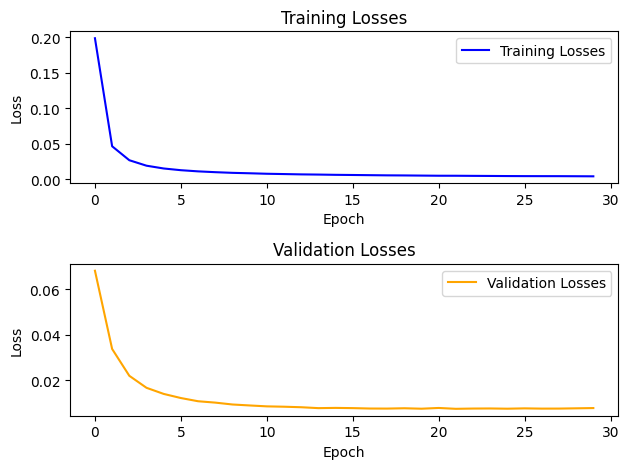

In [86]:
num_epochs = 30
model, train_losses, val_losses = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion)

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

In [93]:
validation(model, val_loader, 10)

  0%|          | 0/10 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '20230530_segm_black_mouse_mnSLA_red_and_black_back\\images\\revert_vertical_ch1_20230309202847_20230309212847@066851.bmp'

100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


IOU: 0.817658904868726
AP: -0.04331221543172362


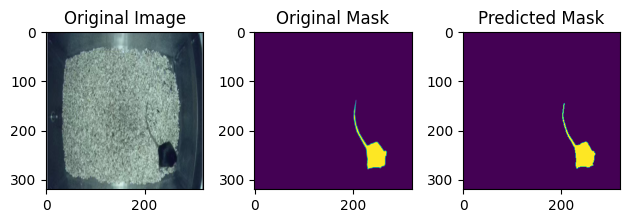

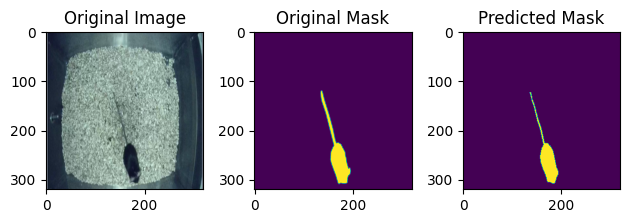

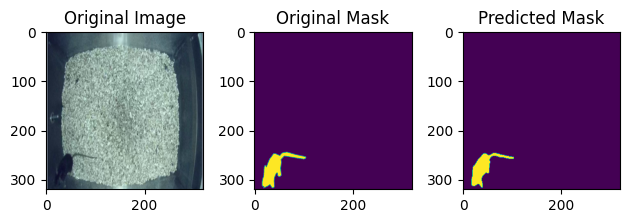

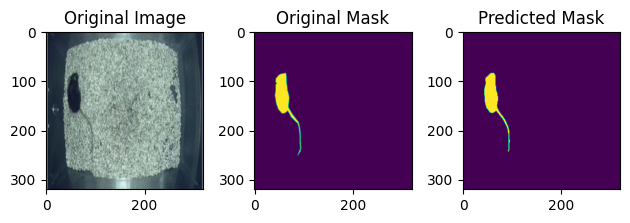

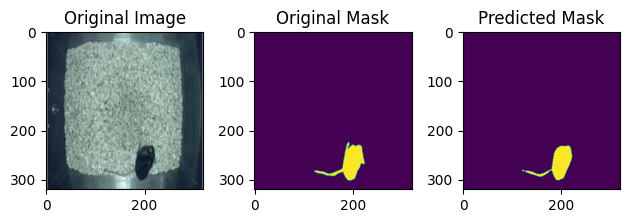

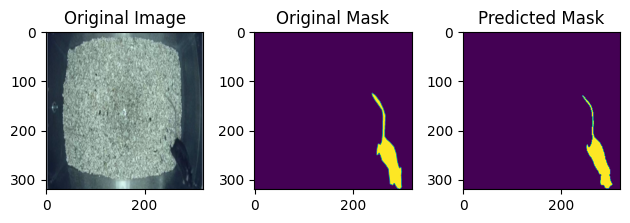

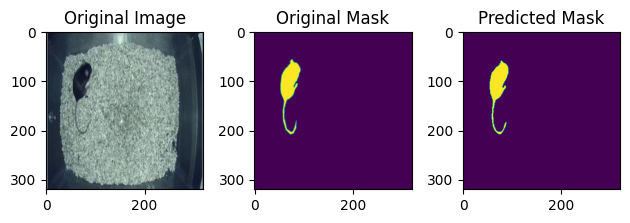

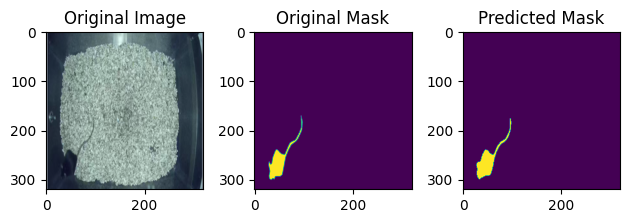

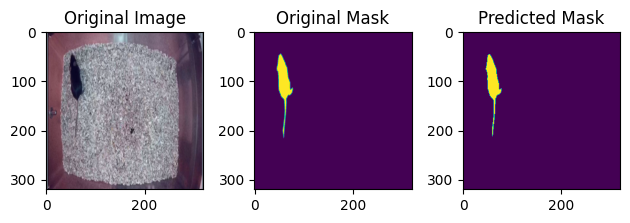

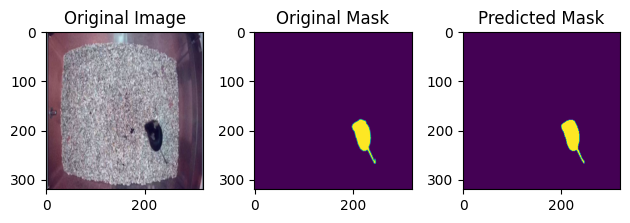

In [96]:
validation(model, test_loader, 10)

In [89]:
delete_generated_images(data_vertical, data_horizontal)